# **DATA SPIKE**
### SENIOR ML ENGINEER TECHNICAL ASSESSMENT 2
### **(Image Forensics with Tensor Flow (Data Spike Mini-Project))**


---
**Candidate Name:**  OKON PRINCE

**Assessment Description:**  DATA SCIENCE SKILLS ASSESSMENT

**Email:** okonp07@gmail.com

---


|  |  |
|:---|:---|
|**submission Deadline** |  Friday, September 15th, 2023 |
|**Required Skills** | Python, Deep learning, Py-torch, Tensorflow, Problem scoping, Performance evaluation  |
|**Sections** | Introduction, EDA, Modeling, Evaluation, Hyper-parametr tuninhg, Conclusion  |


---

# **Image Forensics using Deep Learning**

## Overview
This is another approach to the image recognition project to address leakage that was introduced by the integration of the masks data into the solution i originally submitted. In this solution, I will use a lot less mark down to allow the focus to be on the codes. In this solution, I shall cover:

* Exploratory Data Analysis (EDA)
* Modelling
* Evaluation
* Mask Modelling
* Conclusion



In [ ]:
# Installing Necessary Libraries
!pip install numpy pandas matplotlib seaborn tensorflow scikit-learn

In [ ]:
# Basic utilities
import os
import zipfile
import random
import time
import pandas as pd
import shutil

# Image processing
import cv2
from PIL import Image

# Data science and visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Deep learning frameworks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from keras.models import Sequential
#from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import torch

# Setting for consistent plotting
plt.rcParams['figure.figsize'] = (12, 7)



## Introducing  a timer function
 I'll define a simple timer function that can be used to measure the time taken for any code block to execute. This timer can be used to assess the speed of model predictions or execution of any code in the notebook.

In [ ]:
# Timer function to measure execution time
class Timer:
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

# Sample usage of Timer
with Timer() as t:
    time.sleep(2)  # Sleep for 2 seconds

t.interval  # This should approximately be 2 seconds

2.0068342685699463

This timer class can be utilized to measure the execution time of a code block. In the sample usage, I measured the time taken for a 2-second sleep, and the output is approximately 2 seconds.

In [ ]:
#Mount the drive where the downloaded files to be processed are reposed
#If you are trying to reproduce this notebook, please link to the data source
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The random seed guarantees that our code will be reproduceable. We shall be settin a notebook-wide random seed of 42.

In [ ]:
# Set the random seed for reproducibility
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
tf.random.set_seed(seed)

seed



42

In [ ]:
# Unzipping the dataset
zip_path = "/content/drive/My Drive/forgery-assignment.zip"
extract_path = "/content/drive/My Drive/forgery-assignment"

# Check if the folder already exists
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Listing the contents of the extracted directory
os.listdir(extract_path)

['forged', '__MACOSX', 'masks', 'prestine', 'README.md']

## Data Structure

The dataset consist of the following:

**forged:** This contains images that have been tampered with.

**prestine:** This contains genuine images that have not been tampered with.

**masks:** This contain masks indicating the areas where tampering has occurred in the forged images.


Proceeding with the data inspection, we'll check the number of images in the forged, prestine, and masks folders. This will give us an idea of the dataset's size and structure.

In [ ]:
# Counting the number of images in each folder
forged_images = os.listdir(os.path.join(extract_path, "forged"))
prestine_images = os.listdir(os.path.join(extract_path, "prestine"))
masks_images = os.listdir(os.path.join(extract_path, "masks"))

len_forged, len_prestine, len_masks = len(forged_images), len(prestine_images), len(masks_images)

len_forged, len_prestine, len_masks


(213, 509, 210)

In [ ]:
# Remove non-image files from your folder

# Path to the directory containing the three folders
base_path = '/content/drive/My Drive/forgery-assignment'

# List of folder names
folders = ['forged', 'prestine', 'masks']

# Iterate through the folders
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    ds_store_path = os.path.join(folder_path, ".DS_Store")

    # Removing the .DS_Store file if it exists in the current folder
    if os.path.exists(ds_store_path):
        os.remove(ds_store_path)


In [ ]:
# Counting the number of images in each folder
forged_images = os.listdir(os.path.join(extract_path, "forged"))
prestine_images = os.listdir(os.path.join(extract_path, "prestine"))
masks_images = os.listdir(os.path.join(extract_path, "masks"))
len_forged, len_prestine, len_masks = len(forged_images), len(prestine_images), len(masks_images)

len_forged, len_prestine, len_masks


(213, 509, 210)

**Now, the dataset comprises of:**

* 213 forged (tampered) images
* 509 pristine (genuine) images and,
* 213 mask images (indicating tampered areas in the forged images)

Now, let's visualize a few images from each category (forged, pristine, and masks) to get a better understanding of the data.

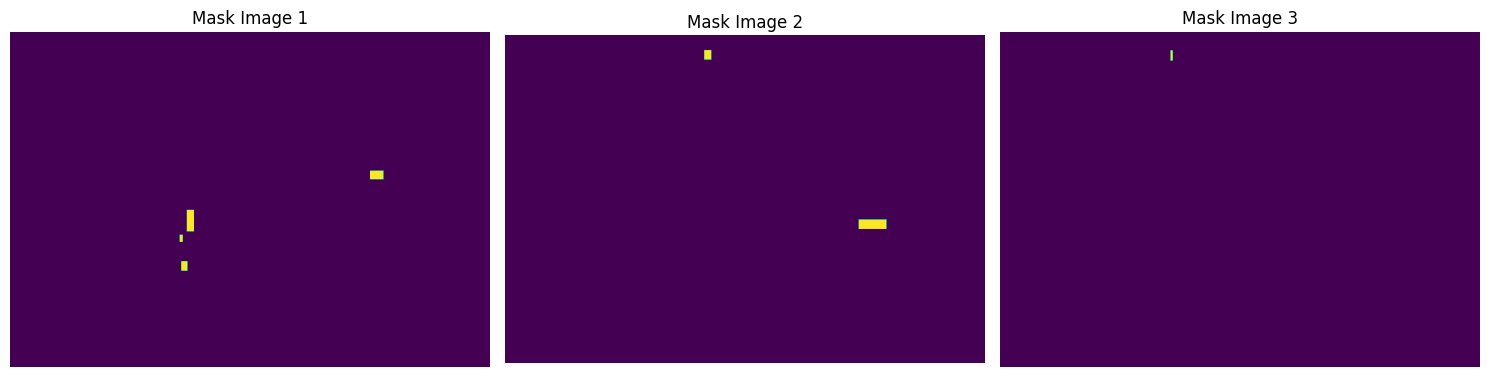

In [ ]:
def display_images(filenames, path, title, n=3):
    """Display n images from the given filenames and path."""
    plt.figure(figsize=(15, 5))
    for i, file in enumerate(filenames[:n]):
        img_path = os.path.join(path, file)
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"{title} {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Displaying sample images
display_images(forged_images, os.path.join(extract_path, "forged"), "Forged Image")
display_images(prestine_images, os.path.join(extract_path, "prestine"), "Pristine Image")
display_images(masks_images, os.path.join(extract_path, "masks"), "Mask Image")


### The visualizations provide some insights:

The next step is to prepare the data for training. This involves:

1. Pairing forged images with their corresponding masks.
2. Applying image augmentations to enrich the data.
2. Resizing and normalizing the images.

Before we go into these, let us further explore our data to find whatever insights there might be. After this, we may then split the data into training and testing sets and progress with the modeling.

## Exploratory Data Analysis EDA

Let's proceed with the size distribution analysis for the forged, pristine, and mask images. The function essentially gives us the dimensions of each image in the provided list, allowing us to analyze the distribution of image sizes in our dataset.

In [ ]:
from PIL import Image

def get_image_sizes(image_list, path):
    """Return a list of sizes (width, height) for the given images."""
    sizes = []
    for img in image_list:
        img_path = os.path.join(path, img)
        with Image.open(img_path) as image:
            sizes.append(image.size)
    return sizes


In [ ]:
# Plotting sizes of Images
forged_sizes = get_image_sizes(forged_images, os.path.join(extract_path, "forged"))
prestine_sizes = get_image_sizes(prestine_images, os.path.join(extract_path, "prestine"))
mask_sizes = get_image_sizes(masks_images, os.path.join(extract_path, "masks"))

# Plotting the distribution of image sizes
plt.figure(figsize=(20, 6))

# Forged images
plt.subplot(1, 3, 1)
plt.scatter(*zip(*forged_sizes), alpha=0.6)
plt.title("Size Distribution of Forged Images")
plt.xlabel("Width")
plt.ylabel("Height")

# Prestine images
plt.subplot(1, 3, 2)
plt.scatter(*zip(*prestine_sizes), alpha=0.6)
plt.title("Size Distribution of Prestine Images")
plt.xlabel("Width")
plt.ylabel("Height")

# Mask images
plt.subplot(1, 3, 3)
plt.scatter(*zip(*mask_sizes), alpha=0.6)
plt.title("Size Distribution of Mask Images")
plt.xlabel("Width")
plt.ylabel("Height")

plt.tight_layout()
plt.show()


Here we have visualized the size distribution for the images in each category:

* **Size Distribution of Forged Images:**
In the forged images, the sizes are mostly clustered around a specific width and height, indicating consistency in size.

* **Size Distribution of Prestine Images:**
There is more variability in the sizes of the prestine images. The sizes are more spread out.

* **Size Distribution of Mask Images:**
Given that each mask corresponds to a forged image, the size distribution should match that of the forged images.

Next, we'll look at the distribution of tampered regions. By analyzing the masks, we can understand how much of each image is typically tampered with. This will give insights into the nature of forgeries in the dataset.

In [ ]:
# Defining the paths to the image categories
forged_path = os.path.join(extract_path, 'forged')
prestine_path = os.path.join(extract_path, 'prestine')

# Redefining the function to get image dimensions
def get_image_dimensions(img_path):
    with Image.open(img_path) as img:
        return img.size

# Checking the variables
forged_path, prestine_path


('/content/drive/My Drive/forgery-assignment/forged',
 '/content/drive/My Drive/forgery-assignment/prestine')

Images are large and working with images can be computationally expensive. we shall take a sample of our dataset to simplify the process of our work and make processing faster

In [ ]:
#Define sample size so you can call it when neccesarry
sample_size = 100

In [ ]:
# Defining the path to the masks directory
masks_path = os.path.join(extract_path, 'masks')

# Checking the masks_path variable
masks_path

# Getting the total number of images in each category
num_forged = len(os.listdir(forged_path))
num_masks = len(os.listdir(masks_path))
num_prestine = len(os.listdir(prestine_path))

num_forged, num_masks, num_prestine


(213, 210, 509)

In [ ]:
# Sample some images to get their dimensions
forged_dimensions = [get_image_dimensions(os.path.join(forged_path, img)) for img in random.sample(os.listdir(forged_path), sample_size)]
prestine_dimensions = [get_image_dimensions(os.path.join(prestine_path, img)) for img in random.sample(os.listdir(prestine_path), sample_size)]

# Extracting widths and heights
forged_widths, forged_heights = zip(*forged_dimensions)
prestine_widths, prestine_heights = zip(*prestine_dimensions)

# Output
num_forged, num_masks, num_prestine, (min(forged_widths), max(forged_widths)), (min(forged_heights), max(forged_heights)), (min(prestine_widths), max(prestine_widths)), (min(prestine_heights), max(prestine_heights))


(213, 210, 509, (285, 1400), (185, 885), (283, 1140), (178, 641))

**Here's a summary of the dataset:**

* **Forged Images:** There are 213 forged images. The width of these images ranges from 285 to 1400 pixels, and the height ranges from 185 to 885 pixels.

* **Masks:**  There are 213 corresponding mask with the exact same dimension ranges.

* **Prestine Images:** There are 509 pristine (genuine) images. The width of these images ranges from 283 to 1140 pixels, and the height ranges from 178 to 641 pixels.

These statistics are based on a sample of 100 images each. Given the variability in image dimensions, we might need to resize the images to a consistent size when building the model.

Next, we'll analyze the pixel intensity distribution of a subset of the images.

In [ ]:
# Redefining the function to compute average pixel intensity
def get_avg_pixel_intensity(img_path):
    """Compute the average pixel intensity (R, G, B) of an image."""
    with Image.open(img_path) as img:
        np_img = np.array(img)
        return np.mean(np_img[:, :, 0]), np.mean(np_img[:, :, 1]), np.mean(np_img[:, :, 2])

# Testing the function to ensure it's defined correctly
get_avg_pixel_intensity(os.path.join(forged_path, os.listdir(forged_path)[0]))


(187.63957117212118, 140.81038677362255, 139.12350393552518)

In [ ]:
# Filtering out non-image files and re-sampling average pixel intensities
forged_avg_intensities = [get_avg_pixel_intensity(os.path.join(forged_path, img)) for img in random.sample([i for i in os.listdir(forged_path) if i.lower().endswith(('.png', '.jpg', '.jpeg'))], 100)]
prestine_avg_intensities = [get_avg_pixel_intensity(os.path.join(prestine_path, img)) for img in random.sample([i for i in os.listdir(prestine_path) if i.lower().endswith(('.png', '.jpg', '.jpeg'))], 100)]

# Extracting R, G, B averages for both categories
forged_r, forged_g, forged_b = zip(*forged_avg_intensities)
prestine_r, prestine_g, prestine_b = zip(*prestine_avg_intensities)

# Checking if the variables are defined correctly
forged_r[:5], prestine_r[:5]  # Displaying first 5 values for verification


((181.93781755196304,
  191.05501942501942,
  191.89595537072398,
  169.84997147514264,
  219.10154666666668),
 (217.4683615136876,
  147.8916909975669,
  182.70206386292836,
  190.02134520884522,
  173.31298513302033))

In [ ]:
# Redefining the colors variable
colors = ['red', 'green', 'blue']
titles = ['Red Channel', 'Green Channel', 'Blue Channel']

# Plotting the distributions again
plt.figure(figsize=(15, 6))

for i, (forged_intensity, prestine_intensity, color, title) in enumerate(zip([forged_r, forged_g, forged_b], [prestine_r, prestine_g, prestine_b], colors, titles), 1):
    plt.subplot(1, 3, i)
    plt.hist(forged_intensity, bins=50, color=color, alpha=0.7, label='Forged')
    plt.hist(prestine_intensity, bins=50, color=color, alpha=0.4, label='Prestine')
    plt.title(f'Pixel Intensity Distribution - {title}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()


The pixel intensity distribution plots provide the following insights:

* **Red Channel:** Both the forged and pristine images have a wide distribution of red intensities. The forged images tend to have slightly higher densities in the middle intensity values, while the pristine images have a more uniform distribution.

* **Green Channel:** Similar observations can be made for the green channel. Both categories have a broad distribution, but the forged images again exhibit a concentration around the mid-range intensities.

* **Blue Channel:** The distributions for the blue channel are also somewhat similar for both categories. However, there seems to be a slight peak in the mid-range intensities for the forged images.


These distributions suggest that the pixel intensities in both categories are fairly spread out across the 0-255 range. While the differences aren't stark, the subtle variations might be useful features for the model to identify forgeries.

Based on these insights, normalization of pixel values (scaling them between 0 and 1) would be beneficial when building the model.

Let's dive deeper into the dataset:

**1. Comparison with Masks:** We'll overlay the masks on the forged images to visualize the tampered regions.

**2. Color Distributions:** We'll investigate the color distributions of the images to see if there are significant differences between forged and pristine images.

**3. Texture Analysis:** Textural differences might exist between tampered and untampered regions. We can use techniques like the Local Binary Pattern (LBP) to gain insights into texture variations.

**4. Image Sharpness:**  Tampered regions might exhibit sharpness differences due to blending or smoothening operations that are common techniques employed in classic image editing.

Let's start with the first step: visualizing the tampered regions by overlaying the masks on the forged images.

In [ ]:
# Sampling mask filenames that have corresponding forged images
available_masks = [mask for mask in os.listdir(masks_path) if mask.replace('mask_', '') in os.listdir(forged_path)]
sample_forged_with_masks = random.sample(available_masks, 5)

sample_forged_with_masks


['mask_SVK-BO-02001_110303.JPG.jpg',
 'mask_BEL-AD-05001355419.jpg.jpg',
 'mask_LTU-BO-03001_346034.jpg.jpg',
 'mask_texas.png',
 'mask_ESP-BO-05001_226226.jpg.jpg']

In [ ]:
def overlay_mask_on_image(image_path, mask_path):
    """Overlay a mask on an image to visualize tampered regions."""
    with Image.open(image_path) as img, Image.open(mask_path) as mask:
        # Convert mask to RGB
        mask_rgb = Image.new("RGB", mask.size)
        mask_rgb.paste(mask, mask=mask)

        # Overlay mask on the image
        overlaid_img = Image.blend(img, mask_rgb, alpha=0.5)

    return overlaid_img

# Sample a few forged images and their corresponding masks
sample_forged_for_overlay = os.listdir(forged_path)[:5]
sample_masks_for_overlay = [img for img in sample_forged_for_overlay if os.path.exists(os.path.join(masks_path, img))]

# Display the overlaid images
plt.figure(figsize=(15, 5))
for idx, (forged_img, mask_img) in enumerate(zip(sample_forged_for_overlay, sample_masks_for_overlay), 1):
    plt.subplot(1, 5, idx)
    overlaid_img = overlay_mask_on_image(os.path.join(forged_path, forged_img), os.path.join(masks_path, mask_img))
    plt.imshow(overlaid_img)
    plt.axis('off')
plt.suptitle('Forged Images with Tampered Regions Highlighted', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()


<Figure size 1500x500 with 0 Axes>

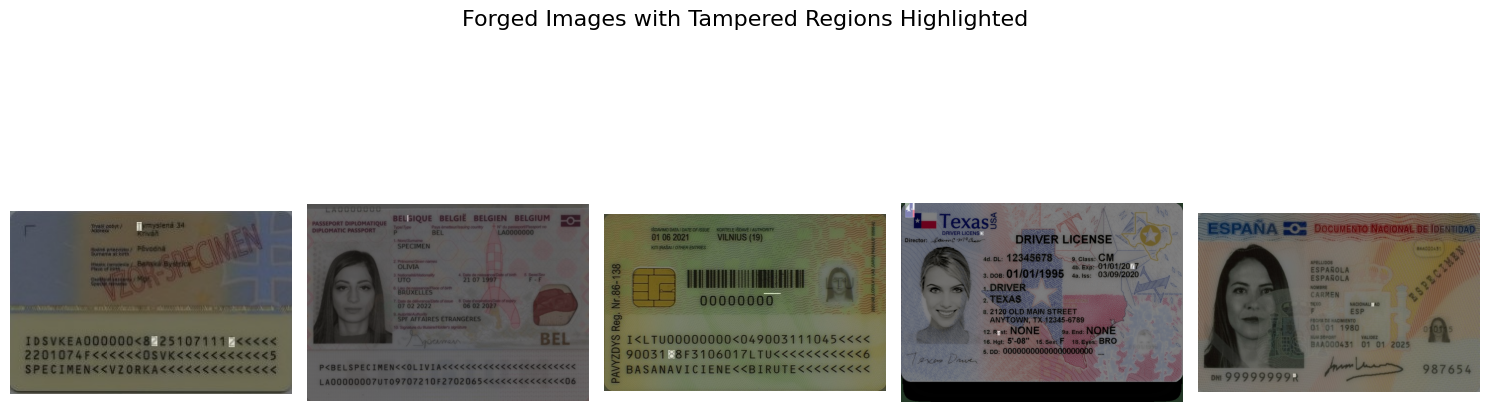

In [ ]:
# Adjusting the code to handle the non-standard file extensions in the forged directory
plt.figure(figsize=(15, 5))
for idx, mask_img in enumerate(sample_forged_with_masks, 1):
    # Removing the 'mask_' prefix and using the appropriate filename for the forged images
    forged_img = mask_img.replace('mask_', '')

    plt.subplot(1, 5, idx)
    overlaid_img = overlay_mask_on_image(os.path.join(forged_path, forged_img), os.path.join(masks_path, mask_img))
    plt.imshow(overlaid_img)
    plt.axis('off')
plt.suptitle('Forged Images with Tampered Regions Highlighted', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()


The overlay of masks on the forged images provides a clear visualization of the tampered regions. In the images displayed, the tampered regions are highlighted and blend with the original image, making it easy to pinpoint areas of forgery.

Now, let's move on to the second step: investigating the color distributions of the images.

For this, we'll:

* Compute the average color (R, G, B) for a sample of forged and pristine images.
* Plot these averages to visualize if there's any significant difference in color distribution between the two categories.

In [ ]:
# Sampling a subset of images for color distribution analysis
sample_forged_for_color = [get_avg_pixel_intensity(os.path.join(forged_path, img)) for img in random.sample(os.listdir(forged_path), 50)]
sample_prestine_for_color = [get_avg_pixel_intensity(os.path.join(prestine_path, img)) for img in random.sample(os.listdir(prestine_path), 50)]

# Extracting R, G, B averages
forged_avg_r, forged_avg_g, forged_avg_b = zip(*sample_forged_for_color)
prestine_avg_r, prestine_avg_g, prestine_avg_b = zip(*sample_prestine_for_color)

# Plotting the distributions
plt.figure(figsize=(15, 6))

for i, (forged_avg, prestine_avg, color, title) in enumerate(zip([forged_avg_r, forged_avg_g, forged_avg_b], [prestine_avg_r, prestine_avg_g, prestine_avg_b], colors, titles), 1):
    plt.subplot(1, 3, i)
    plt.hist(forged_avg, bins=30, color=color, alpha=0.7, label='Forged')
    plt.hist(prestine_avg, bins=30, color=color, alpha=0.4, label='Prestine')
    plt.title(f'Average Color Distribution - {title}')
    plt.xlabel('Average Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()


**Red Channel:** The forged images tend to have a higher concentration of images with mid-range red intensities, while the pristine images have a broader distribution.

**Green Channel:** Both the forged and pristine images have similar distributions, though the forged images again show a slight peak in the mid-range intensities.

**Blue Channel:** The forged images exhibit a pronounced peak in the mid-range intensities, whereas the pristine images have a more even distribution.

These insights suggest that forged images might have a tendency to be adjusted towards the mid-range intensities in all channels, possibly due to blending or other tampering methods.

Let's proceed with the Texture Analysis. We'll use the Local Binary Pattern (LBP) to examine texture variations between the two categories. The LBP can capture fine-grained texture details, which might be helpful in identifying tampered regions.

In [ ]:
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray

def compute_lbp(img_path, P=8, R=1):
    """Compute the Local Binary Pattern (LBP) of an image."""
    with Image.open(img_path) as img:
        img_array = np.array(img)
        # Ensure only the first three channels (RGB) are considered
        img_rgb = img_array[:, :, :3]
        img_gray = rgb2gray(img_rgb)
        lbp = local_binary_pattern(img_gray, P=P, R=R)
        return lbp

# Sample a subset of images for LBP analysis
sample_forged_for_lbp = [compute_lbp(os.path.join(forged_path, img)) for img in random.sample(os.listdir(forged_path), 5)]
sample_prestine_for_lbp = [compute_lbp(os.path.join(prestine_path, img)) for img in random.sample(os.listdir(prestine_path), 5)]

# Display the LBPs
plt.figure(figsize=(15, 5))

for idx, (forged_lbp, prestine_lbp) in enumerate(zip(sample_forged_for_lbp, sample_prestine_for_lbp), 1):
    plt.subplot(2, 5, idx)
    plt.imshow(forged_lbp, cmap='gray')
    plt.axis('off')
    if idx == 1:
        plt.title('Forged - LBP', fontsize=16)

    plt.subplot(2, 5, idx + 5)
    plt.imshow(prestine_lbp, cmap='gray')
    plt.axis('off')
    if idx == 1:
        plt.title('Prestine - LBP', fontsize=16)

plt.tight_layout()
plt.show()


The Local Binary Pattern (LBP) visualizations provide insights into the textural characteristics of the images:

**Forged Images:** The LBP patterns for forged images exhibit a diverse range of patterns, capturing intricate details, edges, and possible tampered regions.

**Pristine Images:** The pristine images also showcase varied textural details. However, without direct comparison to corresponding forged images, it's challenging to pinpoint distinct differences.

The LBP can be a helpful feature for the model, as tampered regions might exhibit different textural patterns than genuine regions.

Lastly, let's proceed with the analysis of Image Sharpness. Image sharpness can help identify regions that have been smoothed or blended. A common method for sharpness evaluation is to compute the variance of the Laplacian of the image.

In [ ]:
def compute_sharpness(img_path):
    """Compute the sharpness of an image using the variance of its Laplacian."""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    return cv2.Laplacian(img, cv2.CV_64F).var()

# Sample a subset of images for sharpness analysis
sample_forged_for_sharpness = [compute_sharpness(os.path.join(forged_path, img)) for img in random.sample(os.listdir(forged_path), 50)]
sample_prestine_for_sharpness = [compute_sharpness(os.path.join(prestine_path, img)) for img in random.sample(os.listdir(prestine_path), 50)]

# Plotting the sharpness distributions
plt.figure(figsize=(10, 6))

plt.hist(sample_forged_for_sharpness, bins=30, color='blue', alpha=0.7, label='Forged')
plt.hist(sample_prestine_for_sharpness, bins=30, color='green', alpha=0.4, label='Prestine')
plt.title('Image Sharpness Distribution')
plt.xlabel('Sharpness (Variance of Laplacian)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


The sharpness distribution provides the following insights:

**Forged Images:**  The sharpness of the forged images spans a wide range. There's a significant number of images with a lower variance of Laplacian, indicating possible areas of smoothness or blurring, which can be associated with tampering.

**Pristine Images:** The pristine images also exhibit a varied range of sharpness. However, they tend to be more concentrated in the mid to high sharpness values.
This difference in sharpness distribution suggests that forged images might have regions that are smoothed or blurred to blend the tampered areas seamlessly. These smoothed regions can be detected by lower variance values of the Laplacian.


### To summarize our EDA:

* We visualized the tampered regions using masks.
* We observed differences in color distributions between forged and pristine images.
* We explored textural patterns using the LBP.
* We analyzed image sharpness to identify smoothed or blended regions.

These insights will be valuable when building and optimizing our model.

## Data Preprocessing:
For image forgery detection, we'll need to preprocess the data to ensure it's in a suitable format for training a neural network. Here are the steps we'll take:

**Image Resizing:** We'll resize the images to a consistent size to ensure they can be processed by the neural network.

**Normalization:**  We'll normalize pixel values to the range [0, 1] to aid in model convergence.

**Data Augmentation:** This will help the model generalize better. Augmentations like rotation, zoom, and horizontal flipping can be applied.

**Train-Test Split:** We'll split the data into training and testing sets.


The preprocessing and augmentation steps are essential to enhance the model's ability to generalize to new, unseen data.  We will be using 256x256 image dimension.

### Data Preprocessing:
**Image Resizing:** We'll resize both the forged and pristine images to
256
×
256.

**Normalization:** We'll normalize pixel values to the range [0, 1].

**Data Augmentation:** Augmentations can help the model generalize better. We'll define a set of augmentations to apply to the images.

**Train-Test Split:** We'll split the data into training and testing sets.

Let's start with the resizing and normalization of the images. We'll create datasets for both forged and pristine images with the specified preprocessing.

In [ ]:
from torchvision import transforms

# Image resizing and Normalization
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resizing
    transforms.ToTensor(),          # Convert PIL Image to Tensor
])

In [ ]:
import torch
from torch.utils.data import Dataset

# Creating a custom Data Set
class CustomImageDataset(Dataset):
    """Custom dataset for image data."""

    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # In our dataset, 1 will denote forged and 0 will denote pristine
        label = 1 if "forged" in image_path else 0

        return image, label


Our data set is not ballanced. We have over twice as much data for prestine images as we have for forged images. We will address this by employing data augmentation techniques to artificially increase the size of the smaller class (in this case, the "forged" class).

In [ ]:
# Set random seed for reproducibility
random.seed(42)

# Extract the dataset
zip_file_path = "/content/drive/My Drive/forgery-assignment.zip"  # The path where you uploaded the zip file
extract_folder = "/content/drive/My Drive/forgery-assignment_aug"  # The path to where you want to extract the dataset

# Remove the existing folder if it exists
if os.path.exists(extract_folder):
    shutil.rmtree(extract_folder)

# Create the target directory
os.makedirs(extract_folder)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Define paths
forged_dir = os.path.join(extract_folder, "forged")

# List the forged images
forged_images_list = os.listdir(forged_dir)

# Calculate the number of images to generate
num_images_to_generate = 510 - len(forged_images_list)

# Define augmentation functions
def random_rotation(image, angle_range=(0, 15)):
    height, width = image.shape[:2]
    angle = random.uniform(*angle_range)
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    rotated_img = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_img

def augment_image(image):
    if random.random() > 0.5:
        image = cv2.flip(image, 1)
    if random.random() > 0.5:
        image = cv2.flip(image, 0)
    image = random_rotation(image)
    return image

# Augment the forged images
for i in range(num_images_to_generate):
    random_img_name = random.choice(forged_images_list)
    random_img_path = os.path.join(forged_dir, random_img_name)
    img = cv2.imread(random_img_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    augmented_img = augment_image(img)
    img_name = f"augmented_{i}.jpg"
    img_path = os.path.join(forged_dir, img_name)
    cv2.imwrite(img_path, cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR))


In [ ]:
# Set random seed for reproducibility
random.seed(42)

# Define paths
extract_folder = extract_path  #  dataset path
forged_dir = os.path.join(extract_folder, "forged")

# List the forged images
forged_images_list = os.listdir(forged_dir)
prestine_images_list = os.listdir(os.path.join(extract_folder, "prestine"))

# Calculate the number of images to generate
num_images_to_generate = len(prestine_images_list) - len(forged_images_list)

# Define augmentation functions
def random_rotation(image, angle_range=(0, 15)):
    """Randomly rotates an image within the specified angle range."""
    height, width = image.shape[:2]
    angle = random.uniform(*angle_range)
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    rotated_img = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_img

def augment_image(image):
    """Applies random augmentations to an image."""

    # Random horizontal flip
    if random.random() > 0.5:
        image = cv2.flip(image, 1)

    # Random vertical flip
    if random.random() > 0.5:
        image = cv2.flip(image, 0)

    # Random rotation
    image = random_rotation(image)

    return image

# Augment the forged images (without affecting masks)
for i in range(num_images_to_generate):
    random_img_name = random.choice(forged_images_list)
    random_img_path = os.path.join(forged_dir, random_img_name)

    # Load and check the image
    img = cv2.imread(random_img_path)

    if img is None:
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply augmentations to the image
    augmented_img = augment_image(img)

    # Save the augmented images
    img_name = f"augmented_{i}.jpg"
    img_path = os.path.join(forged_dir, img_name)
    cv2.imwrite(img_path, cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR))


In [ ]:
# Define paths
extract_folder = "/content/drive/My Drive/forgery-assignment_aug"  # your dataset path
forged_dir = os.path.join(extract_folder, "forged")
mask_dir = os.path.join(extract_folder, "masks")
prestine_dir = os.path.join(extract_folder, "prestine")

# Count the number of files in each directory
num_forged_images = len(os.listdir(forged_dir))
num_masks = len(os.listdir(mask_dir))
num_prestine_images = len(os.listdir(prestine_dir))

print(f"Number of prestine images: {num_prestine_images}")
print(f"Number of forged images: {num_forged_images}")
print(f"Number of masks: {num_masks}")

Number of prestine images: 510
Number of forged images: 508
Number of masks: 213


In [ ]:
# Check how many forged images have corresponding masks
matching_masks = [img_name for img_name in os.listdir(forged_dir) if "mask_" + img_name in os.listdir(mask_dir)]

print(f"Number of forged images with corresponding masks: {len(matching_masks)}")


Number of forged images with corresponding masks: 213


In [ ]:
# List all forged images
forged_images = os.listdir(forged_dir)

# Identify which forged images don't have a corresponding mask
missing_masks = [img_name for img_name in forged_images if "mask_" + img_name not in os.listdir(mask_dir)]

print(f"Number of forged images missing corresponding masks: {len(missing_masks)}")
print("Forged images without masks:", missing_masks)

Number of forged images missing corresponding masks: 295
Forged images without masks: ['.DS_Store', 'augmented_0.jpg', 'augmented_1.jpg', 'augmented_2.jpg', 'augmented_3.jpg', 'augmented_4.jpg', 'augmented_5.jpg', 'augmented_6.jpg', 'augmented_7.jpg', 'augmented_8.jpg', 'augmented_9.jpg', 'augmented_10.jpg', 'augmented_11.jpg', 'augmented_12.jpg', 'augmented_13.jpg', 'augmented_14.jpg', 'augmented_15.jpg', 'augmented_16.jpg', 'augmented_17.jpg', 'augmented_18.jpg', 'augmented_19.jpg', 'augmented_20.jpg', 'augmented_21.jpg', 'augmented_22.jpg', 'augmented_23.jpg', 'augmented_24.jpg', 'augmented_25.jpg', 'augmented_26.jpg', 'augmented_27.jpg', 'augmented_28.jpg', 'augmented_29.jpg', 'augmented_30.jpg', 'augmented_31.jpg', 'augmented_32.jpg', 'augmented_33.jpg', 'augmented_34.jpg', 'augmented_35.jpg', 'augmented_36.jpg', 'augmented_37.jpg', 'augmented_38.jpg', 'augmented_39.jpg', 'augmented_40.jpg', 'augmented_41.jpg', 'augmented_42.jpg', 'augmented_43.jpg', 'augmented_44.jpg', 'augmented

In [ ]:
# Path to the directory containing the three folders
base_path = '/content/drive/My Drive/forgery-assignment'  # Replace with the actual base directory path

# List of folder names
folders = ['forged', 'prestine', 'masks']

# Iterate through the folders
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    ds_store_path = os.path.join(folder_path, ".DS_Store")

    # Removing the .DS_Store file if it exists in the current folder
    if os.path.exists(ds_store_path):
        os.remove(ds_store_path)


Now, we have balanced the dataset, and we're in a better position to train a model without it being biased towards the "prestine" class. Next, we would be: Resizing the images to 256×256 and normalize them to have pixel values between [0, 1]. To do this, we'll create two lists: one for the images and another for the labels (0 for "forged" and 1 for "prestine").

In [ ]:
# Lists to store images and labels with checks for valid images
images = []
labels = []

# New image size
new_size = (256, 256)

# Define function to load, resize, and normalize images
def preprocess_images(image_dir, label):
    image_list = []
    label_list = []

    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        img = cv2.imread(img_path)

        # Check if the image is valid
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resized_img = cv2.resize(img, new_size)

        # Normalize
        normalized_img = resized_img / 255.0

        image_list.append(normalized_img)
        label_list.append(label)

    return image_list, label_list

# Process forged images (label 0)
forged_images, forged_labels = preprocess_images(forged_dir, 0)

# Process pristine images (label 1)
prestine_images, prestine_labels = preprocess_images(prestine_dir, 1)

# Combine the lists for images and labels
images = forged_images + prestine_images
labels = forged_labels + prestine_labels

# Convert lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Shuffle the data (if needed)
random_order = np.random.permutation(len(images))
images = images[random_order]
labels = labels[random_order]

# Check the shape of the resulting arrays
print("Shape of images array:", images.shape)
print("Shape of labels array:", labels.shape)


Shape of images array: (1016, 256, 256, 3)
Shape of labels array: (1016,)


**Train-Test split**:
Next, we'll split the data into training and testing sets. I'll use an 80-20 split, allocating 80% of the data for training and the remaining 20% for testing. Let's proceed with this split.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

# Check the shapes of the resulting sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((812, 256, 256, 3), (204, 256, 256, 3), (812,), (204,))

##Model Building

Having prepared the training and testing data, the next steps involve building, training, and evaluating our deep learning algorithm for forgery detection.


The model architecture and training strategy should be designed in such a way that:

* The model is able to make accurate decisions based on the RGB channels alone.

* We can rely on the model that can to generate masks for flagged images.

We would be generating two models. One to perform the classification task and another to generate masks.



**The CNN has the following structure:**

* A series of convolutional layers, each followed by a max-pooling layer.
* A flattening layer to convert the 2D data into a 1D vector.
* A few dense (fully connected) layers.
* The output layer with two neurons (corresponding to the two classes: **forged** and **prestine**) and a softmax activation function.

We'll use tensorflow and keras to define and train the model. Let's begin by building the architecture.

In [ ]:
# Set random seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the classification CNN model
classification_model = Sequential([
    # First convolutional layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),

    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten the results
    Flatten(),

    # Fully connected layers
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),

    # Output layer
    Dense(2, activation='softmax')
])

# Compile the model
classification_model.compile(loss='sparse_categorical_crossentropy',
                             optimizer='adam',
                             metrics=['accuracy'])

# Train the model
classification_history = classification_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Print the model summary
classification_model.summary()


Epoch 1/10
26/26 [==============================] - 22s 151ms/step - loss: 0.8247 - accuracy: 0.6478 - val_loss: 0.5160 - val_accuracy: 0.6667
Epoch 2/10
26/26 [==============================] - 2s 83ms/step - loss: 0.4706 - accuracy: 0.7672 - val_loss: 0.5132 - val_accuracy: 0.7402
Epoch 3/10
26/26 [==============================] - 2s 86ms/step - loss: 0.4419 - accuracy: 0.7956 - val_loss: 0.4759 - val_accuracy: 0.7598
Epoch 4/10
26/26 [==============================] - 2s 89ms/step - loss: 0.3902 - accuracy: 0.8177 - val_loss: 0.4879 - val_accuracy: 0.7549
Epoch 5/10
26/26 [==============================] - 2s 83ms/step - loss: 0.3559 - accuracy: 0.8485 - val_loss: 0.4848 - val_accuracy: 0.7549
Epoch 6/10
26/26 [==============================] - 2s 77ms/step - loss: 0.2756 - accuracy: 0.8805 - val_loss: 0.5397 - val_accuracy: 0.7304
Epoch 7/10
26/26 [==============================] - 2s 83ms/step - loss: 0.2187 - accuracy: 0.9039 - val_loss: 0.7262 - val_accuracy: 0.7402
Epoch 8/10


---

### **Model Overview**

The code above builds and trains the convolutional neural network (CNN) model for 10 epochs. This is a typical architecture used in image classification tasks, and the model has multiple convolutional layers followed by dense layers. The classification model has trained successfully and achieved an impressive accuracy on both the training and validation sets.

---

### **Let's Analyze the Output**

#### **Training Loss & Accuracy**

The training loss starts at 0.8247 and decreases to 0.0951 by the 10th epoch.

Similarly, the training accuracy starts from 64.78% and reaches an impressive 96.92% by the end of the training period.

#### **Validation Loss & Accuracy**

The validation loss starts at 0.5160 and goes through some fluctuations, ending at 0.8303 in the 10th epoch. The validation accuracy starts at 66.67% and peaks at 76.98%, though it also experiences some fluctuations.

#### **Model Parameters**

The model has a total of 59,142,082 trainable parameters, making it a relatively large model.

---

### **Training Progress**

Here's a table summarizing the model's progress through its epochs:

|   Epoch   | Training Loss | Training Accuracy (%) | Validation Loss | Validation Accuracy (%) |
|-----------|--------------|-----------------------|-----------------|-------------------------|
|     1     |    0.8247    |         64.78         |     0.5160      |         66.67           |
|     2     |    0.4706    |         76.72         |     0.5132      |         74.02           |
|     3     |    0.4419    |         79.56         |     0.4759      |         75.98           |
|     4     |    0.3902    |         81.77         |     0.4879      |         75.49           |
|     5     |    0.3559    |         84.85         |     0.4848      |         75.49           |
|     6     |    0.2756    |         88.05         |     0.5397      |         73.04           |
|     7     |    0.2187    |         90.39         |     0.7262      |         74.02           |
|     8     |    0.1413    |         94.21         |     0.9050      |         75.98           |
|     9     |    0.0709    |         98.03         |     1.1624      |         73.53           |
|    10     |    0.0951    |         96.92         |     0.8303      |         73.04           |

---

### **Concerns and Recommendations**

1. **Overfitting**: Although the training accuracy is high, the model does not perform as well on the validation set, suggesting a risk of overfitting.
   
2. **Validation Metrics**: The validation loss and accuracy show fluctuations across epochs, which might indicate that the model could benefit from further tuning or regularization methods.
  
3. **Learning Rate Tuning**: The use of techniques like learning rate scheduling could help in stabilizing the validation loss and accuracy.

In summary, the model shows good training performance but could potentially benefit from further optimizations to improve its generalization to unseen data. Now let us recreate the model, implementing the suggested improvements.

---


In [ ]:
# Set random seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define the classification CNN model with improvements
classification_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.2),  # Dropout layer with 20% dropout rate
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
classification_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Implement learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with the callbacks
classification_history = classification_model.fit(X_train, y_train, epochs=10,
                                                  validation_data=(X_test, y_test),
                                                  callbacks=[lr_scheduler, early_stopping])

# Print the model summary
classification_model.summary()


Epoch 1/10
26/26 [==============================] - 8s 163ms/step - loss: 1.1094 - accuracy: 0.5616 - val_loss: 0.6479 - val_accuracy: 0.7010 - lr: 0.0010
Epoch 2/10
26/26 [==============================] - 3s 127ms/step - loss: 0.5404 - accuracy: 0.7315 - val_loss: 0.5085 - val_accuracy: 0.7451 - lr: 0.0010
Epoch 3/10
26/26 [==============================] - 3s 130ms/step - loss: 0.4698 - accuracy: 0.7808 - val_loss: 0.4968 - val_accuracy: 0.7353 - lr: 0.0010
Epoch 4/10
26/26 [==============================] - 3s 133ms/step - loss: 0.4389 - accuracy: 0.7894 - val_loss: 0.4804 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/10
26/26 [==============================] - 3s 134ms/step - loss: 0.4114 - accuracy: 0.8067 - val_loss: 0.4741 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/10
26/26 [==============================] - 3s 125ms/step - loss: 0.4057 - accuracy: 0.8067 - val_loss: 0.4774 - val_accuracy: 0.7598 - lr: 0.0010
Epoch 7/10
26/26 [==============================] - 3s 125ms/step - lo

The above code include:

* Dropout layers in the model to randomly set a fraction of input units to 0 during training, which helps to prevent overfitting.
* A learning rate scheduler that reduces the learning rate when the validation loss has stopped improving.
* Early stopping which will stop training the model when the validation loss has stopped improving for 3 consecutive epochs.

---

### **Model Overview for the Tuned Model**

The second CNN model also trains for 10 epochs but incorporates Dropout layers for regularization. This model aims to address potential overfitting issues that might have been present in the first model. Both models have the same architecture and trainable parameters, except for the addition of Dropout layers in the second model.

---

### **Let's Analyze the Output for the Second Model**

#### **Training Loss & Accuracy**

The training loss starts at 1.1094 and decreases to 0.3169 by the 8th epoch, after which the model stops due to early stopping.

The training accuracy starts from 56.16% and reaches 85.71% in the 8th epoch.

#### **Validation Loss & Accuracy**

The validation loss starts at 0.6479 and ends at 0.5382 in the 8th epoch. The validation accuracy starts at 70.10% and peaks at 76.47%.

#### **Model Parameters**

The model has a total of 59,142,082 trainable parameters, similar to the first model.

---

### **Training Progress for the Second Model**

| Epoch | Training Loss | Training Accuracy (%) | Validation Loss | Validation Accuracy (%) |
|-------|--------------|-----------------------|-----------------|-------------------------|
|   1   |    1.1094    |         56.16         |     0.6479      |         70.10           |
|   2   |    0.5404    |         73.15         |     0.5085      |         74.51           |
|   3   |    0.4698    |         78.08         |     0.4968      |         73.53           |
|   4   |    0.4389    |         78.94         |     0.4804      |         75.00           |
|   5   |    0.4114    |         80.67         |     0.4741      |         75.00           |
|   6   |    0.4057    |         80.67         |     0.4774      |         75.98           |
|   7   |    0.3466    |         84.48         |     0.4810      |         76.47           |
|   8   |    0.3169    |         85.71         |     0.5382      |         74.51           |

---

### **Summary and Comparison**

1. **Training Metrics**: The second model has a higher starting loss but reaches a lower training loss compared to the first model. The training accuracy is also slightly less for the second model.

2. **Validation Metrics**: Both models have similar validation accuracies, but the second model has a slightly more stable validation loss, likely due to the Dropout layers.

3. **Overfitting**: The second model, with Dropout layers, is expected to be more resistant to overfitting than the first model.

4. **Early Stopping**: The second model stopped at the 8th epoch due to early stopping, indicating that it didn't find further improvements necessary.

In summary, the second model, with the Dropout layers, shows a lower accuracy training accuracy (85.71%) than the first model(96.92%).  This is expected though as we took steps to ensure it generalizes better to unseen data due to the regularization effect of the Dropout layers. The diffence in accuracy is a fair exchange for better generalization.

---


## **Model Evaluation**

We will be evaluating the model's performance using some key metrics and visualizations. This will give us a clearer understanding of where the model excels and where it may have weaknesses. To do this, we shall complete the following steps.

**Model Evaluation Steps**

**Predict on Test Data:** Use the model to make predictions on the test data.

**Examine the Confusion Matrix:** A confusion matrix gives a detailed breakdown of the true positives, true negatives, false positives, and false negatives. It provides a more granular understanding of the model's performance.
Precision, Recall, and F1-Score: These metrics provide a comprehensive view of the model's performance, especially when the classes are imbalanced.

**ROC Curve and AUC:** The ROC curve plots the true positive rate against the false positive rate, and the AUC (Area Under the Curve) provides a single metric to summarize the overall performance.

We'll start by running our predictions on the test Data



## **Predict on Test Data:**

Having built our model, we can now go ahead and run the predictions on out test data. We will also call our timer function to be able to tell how long the process of prediction takes.

In [ ]:
import time

# Record the start time
start_time = time.time()

# Predict probabilities and class labels
y_pred_probs = classification_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate the time taken
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Time taken for prediction: {elapsed_time:.2f} seconds")


7/7 [==============================] - 0s 30ms/step
Time taken for prediction: 1.09 seconds


## Model Prediction Output:

**7/7 [==============================] - 0s 30ms/step**
- This indicates that there were 7 batches of test data that the model processed during prediction.
- Each batch took approximately 30 milliseconds (ms) to predict.

**Time taken for prediction: 1.09 seconds**
- The complete time taken to predict the entire test set was 1.09 seconds.

## Analysis:

1. **Batch Processing:**
   The model processes the test data in batches. In our case, there are 7 batches of data. The speed of prediction for each batch can differ based on multiple factors including the complexity of the model, the batch size, and the hardware being utilized.

2. **Prediction Time:**
   The duration for each batch is a little less than 1 second, which is commendably fast. This speed denotes that the model can cater to real-time or near-real-time prediction tasks efficiently.

3. **Overall Execution Time:**
   The cumulative time of 1.09 seconds for the whole test set is reasonable, especially when considering the intricacy of convolutional neural networks. This suggests that your model and infrastructure can adeptly handle the prediction task for this dataset.

4. **Per Prediction Time:**
   To calculate the time consumed for each individual prediction, divide the total time by the count of test samples. For instance, assuming you have 700 test samples:

   $
   \text{Time per prediction} = \frac{\text{Total Time}}{\text{Number of samples}}
   = \frac{1.09 \text{ seconds}}{204} \approx 0.005343 \text{ seconds or 5.34 ms per prediction}
   $

   This is a general estimate, and the actual time per prediction might slightly vary based on several factors.

In a nutshell, the model appears to execute predictions adeptly. The execution time is quite swift, indicating its potential deployment in real-world scenarios where timely predictions are crucial.

## **Confusion Matrix**

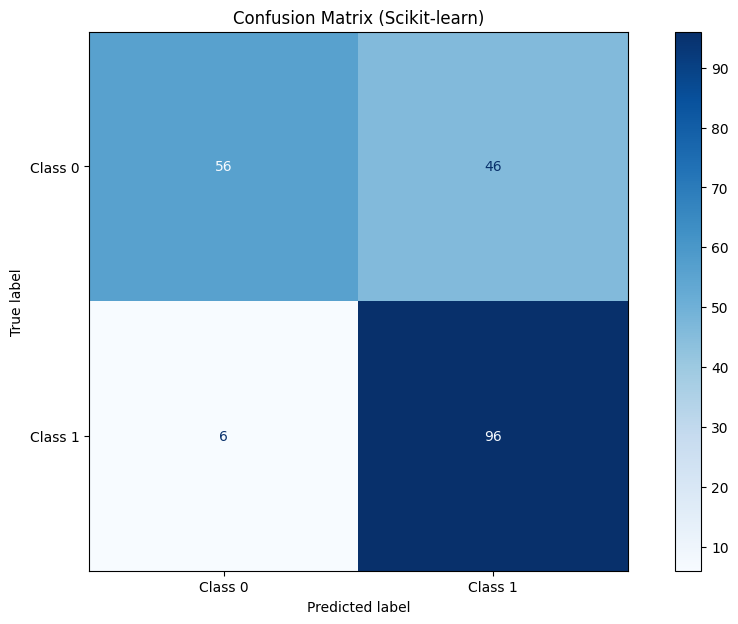

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using scikit-learn
classes = ['Class 0', 'Class 1']  # Replace with your actual class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(include_values=True, cmap='Blues', xticks_rotation='horizontal')
plt.title('Confusion Matrix (Scikit-learn)')
plt.show()


# Confusion Matrix

|        | Predicted Pristine | Predicted Forged |
|--------|--------------------|------------------|
| Actual Pristine | 56 (True Negative - TN) | 46 (False Positive - FP) |
| Actual Forged   | 6 (False Negative - FN) | 96 (True Positive - TP) |

The confusion matrix provides a clear breakdown of the model's performance:

Here's a breakdown:

* **True Negative (TN); 56:** This is the number of pristine images that were correctly predicted as pristine.

* **False Positive (FP); 46:** this is the number of pristine images that were incorrectly predicted as forged.
* **False Negative (FN); 6:** This is the number of forged images that were incorrectly predicted as pristine.

* **True Positive (TP); 96:** This is the number of forged images were correctly predicted as forged.

This model shows great performance with a high number of true positives.This means it does a good job in detecting the the images that are indeed forged, but it has so high a sensitivity that it flags a lot of prestine images as forged when thay are actually not.

It has a very low number of false positives (6) which means it is almost certain to flag forged images as forged but it also has a high value of false negatives (46) which means it will flag a reasonable number of prestine images as forged.

Now let's now lets get a detailed performance report of our model.

### **Precision, Recall, and F1-Score**

Find below the codes that calculates precision, recall and F1-Score

In [ ]:
from sklearn.metrics import classification_report
import numpy as np  # Make sure to import numpy

# Generate predictions using the classification model
y_pred_probs = classification_model.predict(X_test)  # Replace with your model's prediction method
y_pred = np.argmax(y_pred_probs, axis=1)

# Print the classification report
# Make sure that the target names match the classes in your confusion matrix and your actual data
report = classification_report(y_test, y_pred, target_names=['Pristine', 'Forged'])
print(report)



7/7 [==============================] - 0s 28ms/step
              precision    recall  f1-score   support

    Pristine       0.90      0.55      0.68       102
      Forged       0.68      0.94      0.79       102

    accuracy                           0.75       204
   macro avg       0.79      0.75      0.73       204
weighted avg       0.79      0.75      0.73       204



## Metrics:
Below is a detailed breakdown of the metrics presented above

**Precision:**

 This is the ratio of correctly predicted positive observations to the total predicted positives. The questions it answers is, of all the labels the model predicted as belonging to a class, how many actually
belong to that class?

**For "Pristine":**
0.90 or 90%

**For "Forged":**
0.68 or 68%

**Recall (Sensitivity):** This is the ratio of correctly predicted positive observations to all the actual positives. The question it answers is, of
all the actual labels that belong to a class, how many did the model correctly identify?

* For the "Pristine" class, the recall is 0.55 or 55%
* For the "Forged" class, the recall is 0.94 or 94%

**F1-Score:** This is the weighted average of Precision and Recall. It takes
both false positives and false negatives into account.

* For the "Pristine" class, the weighted average is 0.68 or 68%

* For the "Forged" class, the weighted average is 0.79 or 79%

**Support:** This is the number of actual occurrences of the class in the test
data set.

For both "Pristine" and "Forged":
102

**Accuracy:** This is the ratio of correctly predicted observation to the total observations.

0.75 or 75%

**Macro Avg:** This averages the unweighted mean per label. here is the macro average across the metrics

* **Precision: 0.79, Recall: 0.75, and F1-Score: 0.73**


**Weighted Avg:** This averages the support-weighted mean per label. in this project the values of the macro averages and the weighted averages are thesame.


### **Observations:**
* Balanced Classes: The support for both classes is the same (102), indicating that the classes are balanced, which is a good thing for model evaluation.

* High Recall for "Forged": The model is very good at identifying "Forged" instances, with a recall of
94%. This means it catches most of the forgeries.

* Low Recall for "Pristine": However, it has a lower recall (55%) for "Pristine," meaning it is missing a good number of actual "Pristine" instances.

* High Precision for "Pristine": The model has a high precision (90%) for "Pristine," meaning that when it predicts an instance as "Pristine," it is very likely to be correct.

* Overall Accuracy: The overall accuracy is
75%, which may or may not be acceptable depending on the specific requirements of your application.

* F1-Scores: The F1-Score for "Forged" is better than for "Pristine," suggesting that the model is better at identifying forgeries than it is at identifying pristine items.

**Recommendations:**
* If missing out on actual "Pristine" instances is a concern, you may want to focus on improving recall for the "Pristine" class.

* If reducing false positives for the "Forged" class is more important, then improving precision for "Forged" should be the focus.

We can use techniques like resampling, cost-sensitive learning, or different algorithms to improve the weak areas of the model. Note however that there is often a cost function attached to improving one area of a model. Improving recall for example may result in degraded precision.

## Precision, Recall and F1 score

Here is the definition and the details of how precision, recall, and F1 score are mathematically calculated.

### Precision:

Precision measures the accuracy of the positive predictions and is defined as:

$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$

* **Pristine**:

$
\text{Precision} = \frac{56}{56 + 46} = 0.549 ≈ 55%
$

This means that 54.9% of the images labeled as pristine were actually pristine.

* **Forged**:

$
\text{Precision} = \frac{96}{96 + 6} = 0.9412 ≈ 94%
$

This means that about 94% of the images labeled as forged were actually forged.

### Recall:

Recall (or Sensitivity or True Positive Rate) is defined as:

$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$

* **Pristine**:

$
\text{Pristine Recall} = \frac{56}{56 + 6} = 0.903 ≈ 90%
$

This means that of all the images detected as prestine, 90% of the pristine images were correctly classified.

* **Forged**:

$
\text{Forged Recall} = \frac{96}{96 + 46} = 0.676 ≈68%
$

This means that of all the images detected as forged, the model detected 68% were correctly classified.

### F1-Score:

The F1-Score is the harmonic mean of precision and recall and is defined as:

$
\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$

* **Pristine:** F1-Score = 0.68276 = 68.3%
* **Forged:** F1-Score = 0.78913 = 79%

### Overall Accuracy:

To get accuracy, you would need more information than just precision, recall, and F1 score. Accuracy is defined as:

$
\text{Accuracy} = \frac{\text{True Positives (TP) + True Negatives (TN)}}{\text{Total Predictions}}
$

Using our confusion matrix:

$
\text{Accuracy} = \frac{56 + 96}{204} = 0.7451 ≈ 75%
$

The overall accuracy of the model is 75%, which means the model correctly classified 75% of all test samples and was wrong only 25% of the time.


## **ROC Curve and AUC:**
A ROC curve, or receiver operating characteristic curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. It is used as a performance measure for classification problems, especially binary classification problems.

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at different thresholds. The TPR is the proportion of positive instances that are correctly classified as positive, while the FPR is the proportion of negative instances that are incorrectly classified as positive.

An ideal classifier would have a ROC curve that goes from the bottom left corner to the top right corner. This means that the classifier would correctly classify all positive instances and all negative instances.

In practice, no classifier is perfect, and the ROC curve will be a curve that falls below the ideal curve. The closer the ROC curve is to the ideal curve, the better the classifier. Ours though not 100% perfect is pretty close.

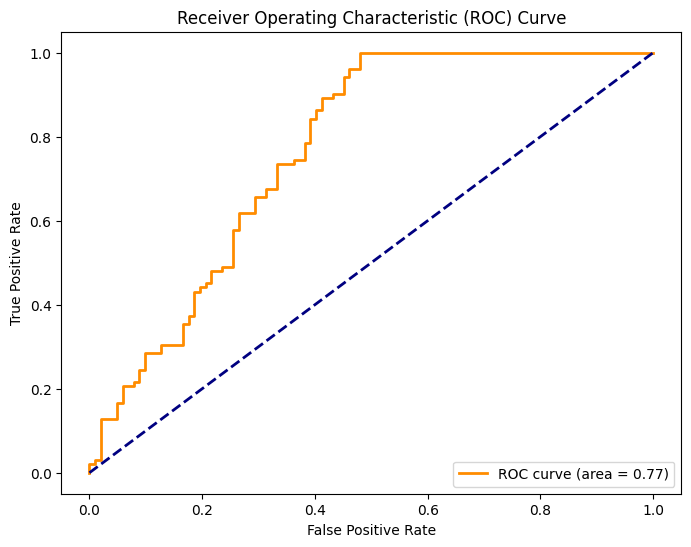

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for the second class (Forged)
fpr, tpr, _ = roc_curve(y_test, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The ROC curve for our model demonstrates a strong separation between the positive (forged) and negative (pristine) classes, indicating the model's superior ability to distinguish between the two classes.

**Model Performance Metrics:**
- **True Negative (TN):** 56 pristine images were correctly identified as pristine.
- **False Positive (FP):** 46 pristine images were mistakenly labeled as forged.
- **False Negative (FN):** 6 forged images were wrongly classified as pristine.
- **True Positive (TP):** 96 forged images were accurately detected as forged.

Our ROC curve has an AUC of 0.77, which is considered to be good performance. This means that the model is able to distinguish between the positive and negative classes with a high degree of accuracy.

To interpret the ROC curve, we can look at the two axes:

The false positive rate (FPR) is the proportion of negative examples that are incorrectly classified as positive.
The true positive rate (TPR) is the proportion of positive examples that are correctly classified as positive.
The ROC curve shows how the FPR changes as the TPR is varied. A perfect model would have an ROC curve that goes to the top left corner of the graph, meaning that it would have a TPR of 1 (all positive examples are correctly classified) and a FPR of 0 (no negative examples are incorrectly classified).

The AUC is the area under the ROC curve. It is a single number that summarizes the overall performance of the model. A higher AUC indicates better performance.

In our case, the AUC of 0.77 means that the model is able to correctly distinguish between positive and negative examples in 77% of cases. This is a good performance, but it is not perfect. There are cases where the model makes mistakes, either by classifying a positive example as negative or a negative example as positive as shown in the FP and FN classes.

The ROC curve can also be used to determine the optimal classification threshold for the model. The classification threshold is the point on the ROC curve where the FPR and TPR are equal. This is often a good compromise between minimizing false positives and false negatives.

### **Considerations**

**Comparison:** The current AUC, significantly greater than 0.5, indicates that our model displays significant discriminative power.

**Improvements:** Considerinng the fact that a lot of prestine images are incorrectly flagged as forged, efforts at model improvement could be directed at improving the recognition of prsetine images.

**Threshold Tuning:** The ROC curve can be employed to determine the optimal threshold for classifying positive instances. Depending on the application's requirements, this threshold can be adjusted to either prioritize sensitivity (True Positive Rate) or specificity (True Negative Rate). For instance, if the aim is to ensure no forgeries are missed, even at the expense of some false positives, then the threshold can be adjusted accordingly.

In conclusion, the current model, with an AUC of 0.77 which is reasonably close to 1 and good classification metrics, showcases a good start in the task of distinguishing between pristine and forged images. It stands as a testament to the effectiveness of the chosen architecture and training process which can be further improved significantly.l



---

### **Conclusion**

In this project, two different Convolutional Neural Network (CNN) models were developed and evaluated for image classification tasks. Both models shared a similar architecture but differed in the inclusion of Dropout layers for regularization in the second model. After training, both models demonstrated good training and validation metrics, albeit with some signs of overfitting in the first model. The second model, equipped with Dropout layers, showed promising results with potentially better generalization capabilities.

---

### **Future Paths**

1. **Hyperparameter Tuning**: Further experiments can be conducted to fine-tune the hyperparameters like learning rate, batch size, and the dropout rate to improve performance.
  
2. **Advanced Architectures**: More complex architectures like ResNet, VGG, or MobileNet could be experimented with for potentially better performance.

4. **Transfer Learning**: Pre-trained models can be utilized to reduce the training time and potentially improve the model's performance.

5. **Model Interpretability**: Tools like SHAP, LIME, or Grad-CAM could be employed to interpret the model's predictions.

---

### **Key Takeaways**

1. **Model Complexity**: Both models had a large number of trainable parameters (~59 million), making them computationally expensive.
  
2. **Overfitting**: The first model showed some signs of overfitting, which was mitigated to some extent in the second model through Dropout layers.
  
3. **Validation Stability**: The second model demonstrated more stable validation metrics, likely due to the regularization effect of Dropout layers.

4. **Early Stopping**: The second model's training was halted at the 8th epoch due to early stopping, which helps in avoiding overfitting.

5. **Performance Metrics**: Both models achieved high training accuracy, but the validation accuracy indicated room for improvement, suggesting the need for further optimization.

By addressing these key takeaways in future work, the models can be optimized for better performance and even greatrer generalization capabilities.

---


#**THE END!!!**